## Initialization

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
import copy

import time

import numpy as np
import pandas as pd
from scipy import ndimage

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import download_file, clear_download_cache
from astropy.utils.data import get_pkg_data_filename

from photutils import data_properties
from photutils import make_source_mask

import matplotlib.pyplot as plt
from matplotlib import colors


from unagi import config
from unagi import hsc
from unagi import plotting
import unagi.mask as msk
from unagi.task import hsc_psf
from unagi.task import hsc_cutout

from photutils import detect_threshold
from photutils import detect_sources
from photutils import deblend_sources

from astropy.convolution import Gaussian2DKernel

import pyimfit
pyimfit.__file__
print('vl2gUfTOHhNYO4cOEZGL+4X17rDJ5WgdWDIE5cqB')
pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

vl2gUfTOHhNYO4cOEZGL+4X17rDJ5WgdWDIE5cqB
Public Data Release Username : colemeyer0
Password : ········
# Get table list from /Users/colemeyer/opt/anaconda3/lib/python3.8/site-packages/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [3]:
def save_to_fits(img, fits_file, wcs=None, header=None, overwrite=True):
        if wcs is not None:
            wcs_header = wcs.to_header()
            img_hdu = fits.PrimaryHDU(img, header=wcs_header)
        else:
            img_hdu = fits.PrimaryHDU(img)

        if os.path.islink(fits_file):
            os.unlink(fits_file)

        img_hdu.writeto(fits_file, overwrite=overwrite)

        return

# Define mask functions

In [4]:
def seg_remove_cen_obj(seg):
        """Remove the central object from the segmentation."""
        seg_copy = copy.deepcopy(seg)
        seg_copy[seg == seg[int(seg.shape[0] / 2.0), int(seg.shape[1] / 2.0)]] = 0

        return seg_copy

In [5]:
def increase_mask_regions(mask, method='uniform', size=7, mask_threshold=0.01):
        """Increase the size of the mask regions using smoothing algorithm."""
        mask_arr = mask.astype('int16')
        mask_arr[mask_arr > 0] = 100
    
        if method == 'uniform' or method == 'box':
            mask_new = ndimage.uniform_filter(mask_arr, size=size)
        elif method == 'gaussian':
            mask_new = ndimage.gaussian_filter(
                mask_arr, sigma=size, order=0)
        else:
            raise ValueError("Wrong method. Should be uniform or gaussian.")
    
        mask_new[mask_new < mask_threshold] = 0
        mask_new[mask_new >= mask_threshold] = 1
    
        return mask_new.astype('uint8')

In [6]:
def create_circular_mask(img, center=None, radius=None):
    """Create a circular mask to apply to an image.
    
    Based on https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
    """
    h, w = img.shape
    
    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [7]:
def get_mask(galaxy):

    cutout = fits.open(cutout_directory+galaxyName+'_i.fits')
    
    RA, Dec, redshift = float(galaxyInfo[galaxy,1]), float(galaxyInfo[galaxy,2]), float(galaxyInfo[galaxy,3])

    coord = SkyCoord(RA, Dec, frame='icrs', unit='deg')
    
    s_phy = 200.0 * u.kpc

    filters = 'i'
    
    label_list = [r"$\rm {}$".format(label) for label in ['Image', 'Mask', 'Variance']]
    
    i_img = cutout[1].data
    i_msk = cutout[2].data
    i_var = cutout[3].data
    
    i_sig = np.sqrt(i_var)
    i_s2n = i_img / i_sig
    
    mask_galaxy = msk.Mask(i_msk, data_release='pdr2')
    
    mask_detect = mask_galaxy.extract('DETECTED')
    mask_bad = mask_galaxy.combine(['NO_DATA', 'SAT'])
    
    threshold = 2.0
    gaussian_sigma = 1.0
    npixels = 5
    nlevels = 64
    contrast = 0.0001
    
    i_thr = detect_threshold(i_img, threshold, background=None, error=i_sig, mask=mask_bad)
    kernel = Gaussian2DKernel(gaussian_sigma, x_size=5, y_size=5)
    kernel.normalize()
    
    i_seg = detect_sources(
        i_img, i_thr, npixels=npixels, connectivity=8, filter_kernel=kernel)
    
    i_seg = deblend_sources(
        i_img, i_seg, npixels=npixels, filter_kernel=kernel, 
        nlevels=nlevels, contrast=contrast, relabel=False)
    
    seg_cmap = plotting.random_cmap(ncolors=256)
    
    i_obj = seg_remove_cen_obj(i_seg.data)
    
    mask_obj = increase_mask_regions(i_obj, method='gaussian', size=3, mask_threshold=3)
    
    cen_mask = create_circular_mask(i_img, radius=100)
    mask_hsc = copy.deepcopy(mask_detect)
    mask_hsc[cen_mask] = False

    mask_hsc_new = increase_mask_regions(
        mask_hsc, method='uniform', size=11, mask_threshold=1)

    mask_final = (mask_obj | mask_hsc_new)
    
    _ = save_to_fits(mask_final, mask_directory+galaxyName+'.fits', overwrite=True)

# Loop


Time Elapsed: 25.98


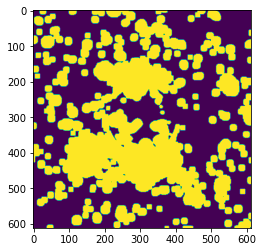

In [8]:
start_time = time.time()

dir_in = '/Users/colemeyer/Documents/Isophotal Twist/ImageFIT/'
cutout_directory = dir_in+'Cutouts/'
mask_directory = dir_in+'Masks/'
if not os.path.isfile(mask_directory):
    os.mkdir(mask_directory)

start=1
end=21

galaxyInfo = np.loadtxt(open(dir_in+"input.csv", encoding='utf-8-sig'), dtype='str', delimiter=",")

for galaxy in range(start-1,end-1):
    
    galaxyName = str(galaxyInfo[galaxy,0])
    
    get_mask(galaxy)
    
end_time = time.time()
elapsed_time = end_time - start_time

print("\nTime Elapsed: "'%.2f' % elapsed_time)